In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
import json
plt.style.use('/raid/lingo/akyurek/mplstyle')
plt.rc('font', serif='Times')
plt.rc('text', usetex=False)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.facecolor'] = 'white'

In [16]:
def average_metrics(results):
    """Average the metrics over samples"""
    metrics = {'precision': {}, 'recall': {}}
    for k in (1, 5, 10,  50, 100):
        if type(list(results[0]['precision'].keys())[0]) == str:
            k = str(k)
        metrics['precision'][k] = np.mean([res['precision'][k] for res in results])
        metrics['recall'][k] = np.mean([res['recall'][k] for res in results])
    metrics['mrr'] = np.mean([res['rr'] for res in results])
    metrics['samples'] = results
    return metrics

In [4]:
"""Google cloud directory that stores results of the experiments"""
BASE_DIR = "./"
METRICS_DIR = os.path.join(BASE_DIR, "metrics")

In [5]:
def metrics_to_df(metrics):
    info = copy.deepcopy(metrics)
    for normalization, results in info.items():
        for layer_config, result in results.items():
            if 'samples' in result:
                del result['samples']
                result['mrr'] = {'1': result['mrr']}
    df = pd.DataFrame(pd.json_normalize(info, sep="+")).transpose()
    df.index = pd.MultiIndex.from_tuples([tuple(k.split("+")) for k, v in df.iterrows()])
    df = pd.melt(df.transpose())
    df.columns = ['normalization', 'layers', 'metrics', 'k', 'score']
    df['layer_type'] = 'A'
    df.loc[df['layers'].str.contains('gradients'), 'layer_type'] = 'gradients'
    df.loc[(df['layers'].str.contains('gradients')) & (df['layers'].str.contains('activations')), 'layer_type'] = 'gradients_and_activations'
    df.loc[(df['layers'] == 'random') | (df['layers'] == 'bm25plus'), 'layer_type'] = 'baseline'
    df = df.replace({'gradients':'G', 'activations': 'A', 'block.': 'L', 'encoder': 'E', 'decoder': 'D'}, regex=True)
    return df

In [40]:
def plot_with_filter(df, filter = lambda x: x, title="Title"):
    plt.figure(figsize=(16, 6))
    sns.scatterplot(data=filter(df), x='layers', y='score', style='normalization', hue='layer_type')
    plt.xticks(rotation=90)
    plt.title(title)
    plt.show()

In [41]:
def visualize_one_experiment(path='/reranker/bm2plus_wbaselines_eos_corrects_all.json'):
    with open(METRICS_DIR + path) as f:
      reranker_metrics = json.load(f)
      if 'mrr' not in reranker_metrics['dot']['random']:
        reranker_metrics['dot']['random'] = reranker_metrics['cosine']['random'] = average_metrics(reranker_metrics['dot']['random'])
      
    df = metrics_to_df(reranker_metrics)
    plot_with_filter(df, filter = lambda x: x[(x['metrics'] == 'precision') & (x['k'] == '10')], title='precision@10')
    plot_with_filter(df, filter = lambda x: x[(x['metrics'] == 'recall') & (x['k'] == '10')], title='recall@10')
    plot_with_filter(df, filter = lambda x: x[(x['metrics'] == 'recall') & (x['k'] == '1')], title='mrr')
  

## With EOS on corrects

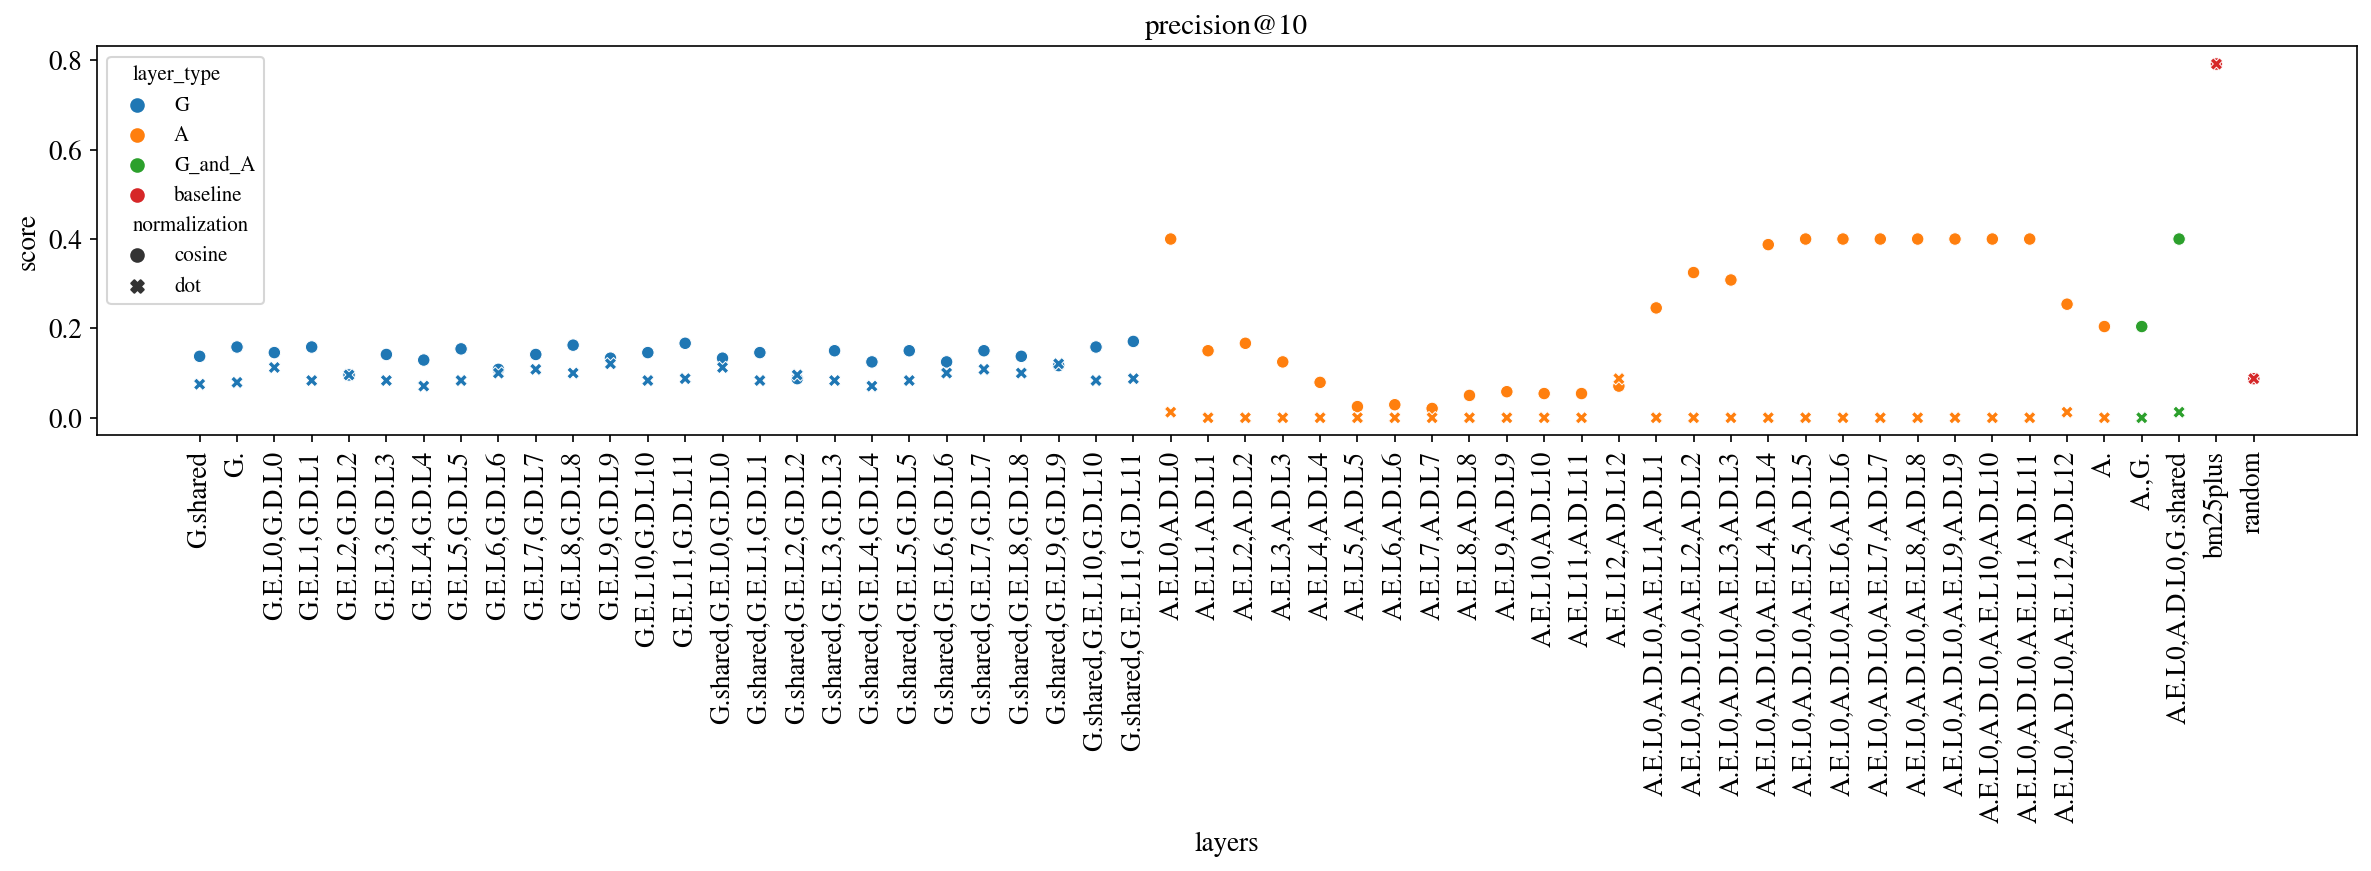

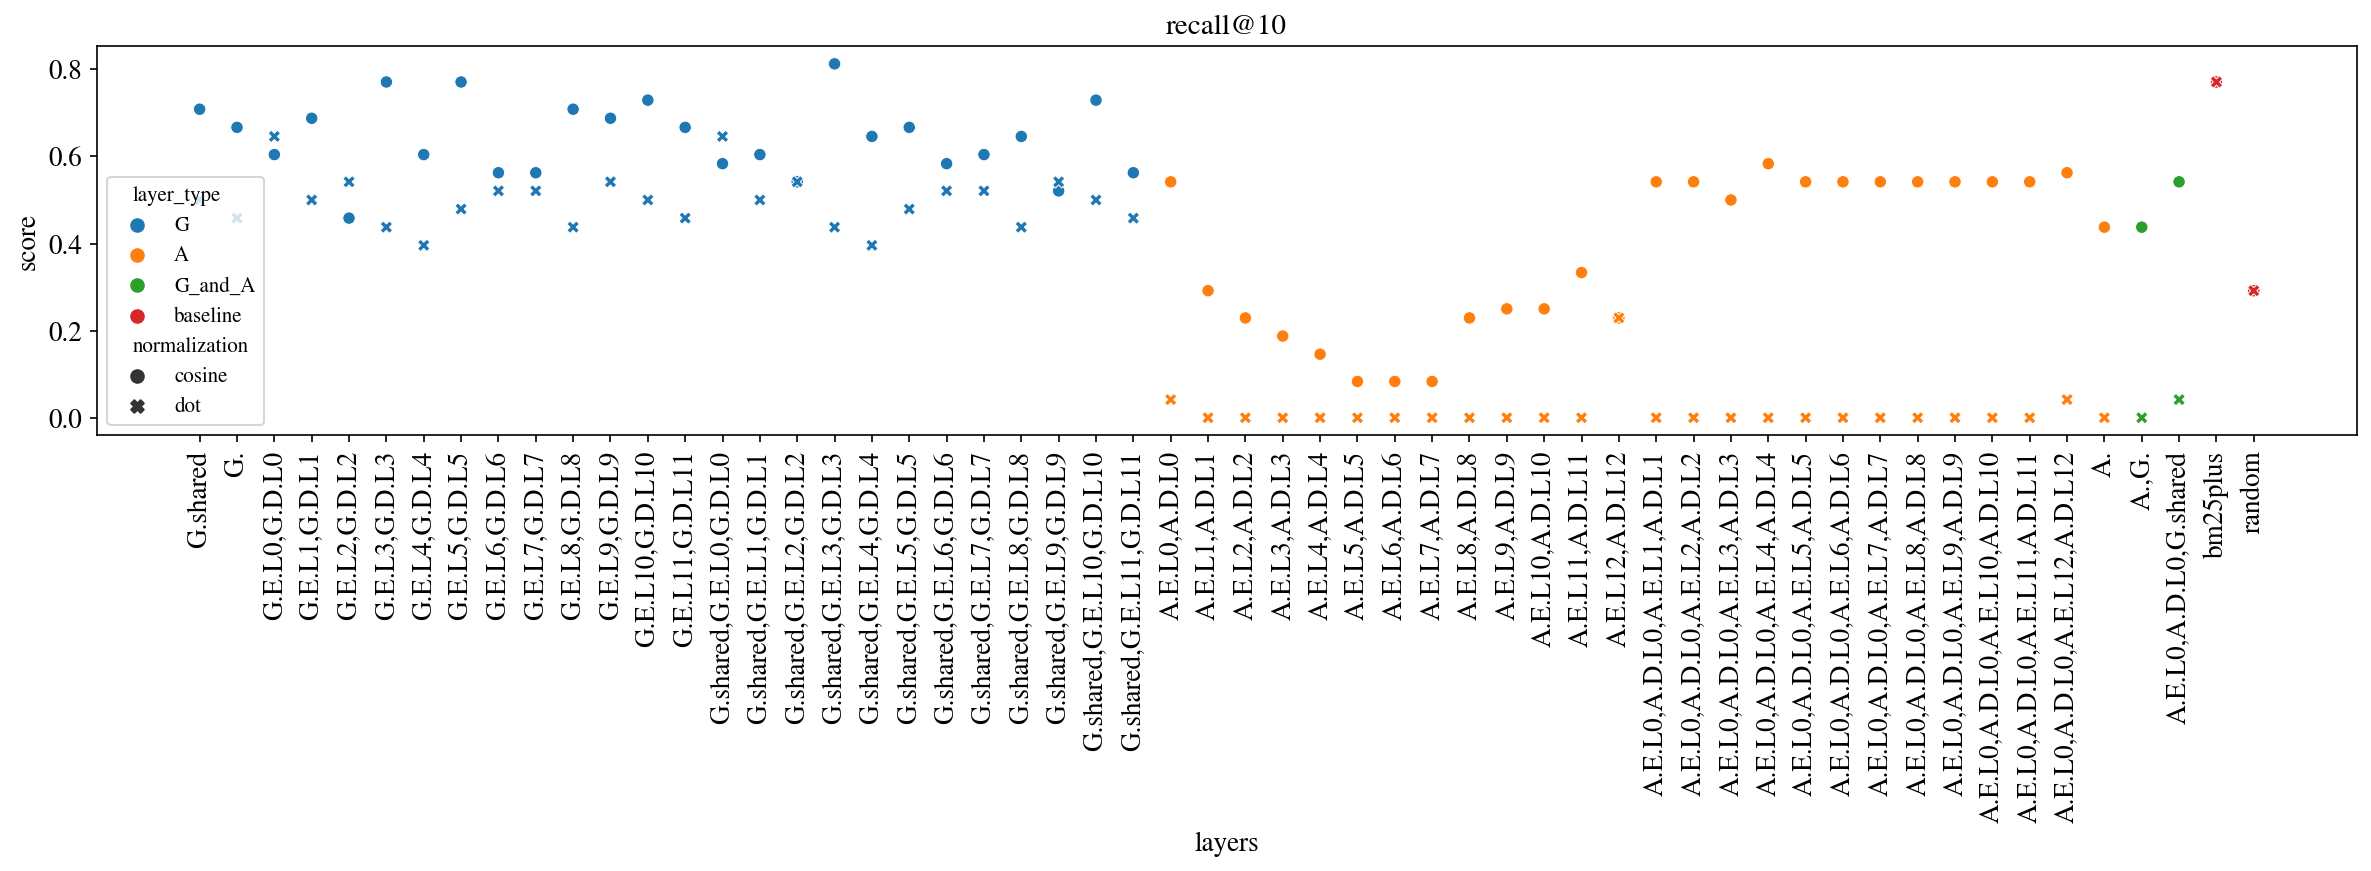

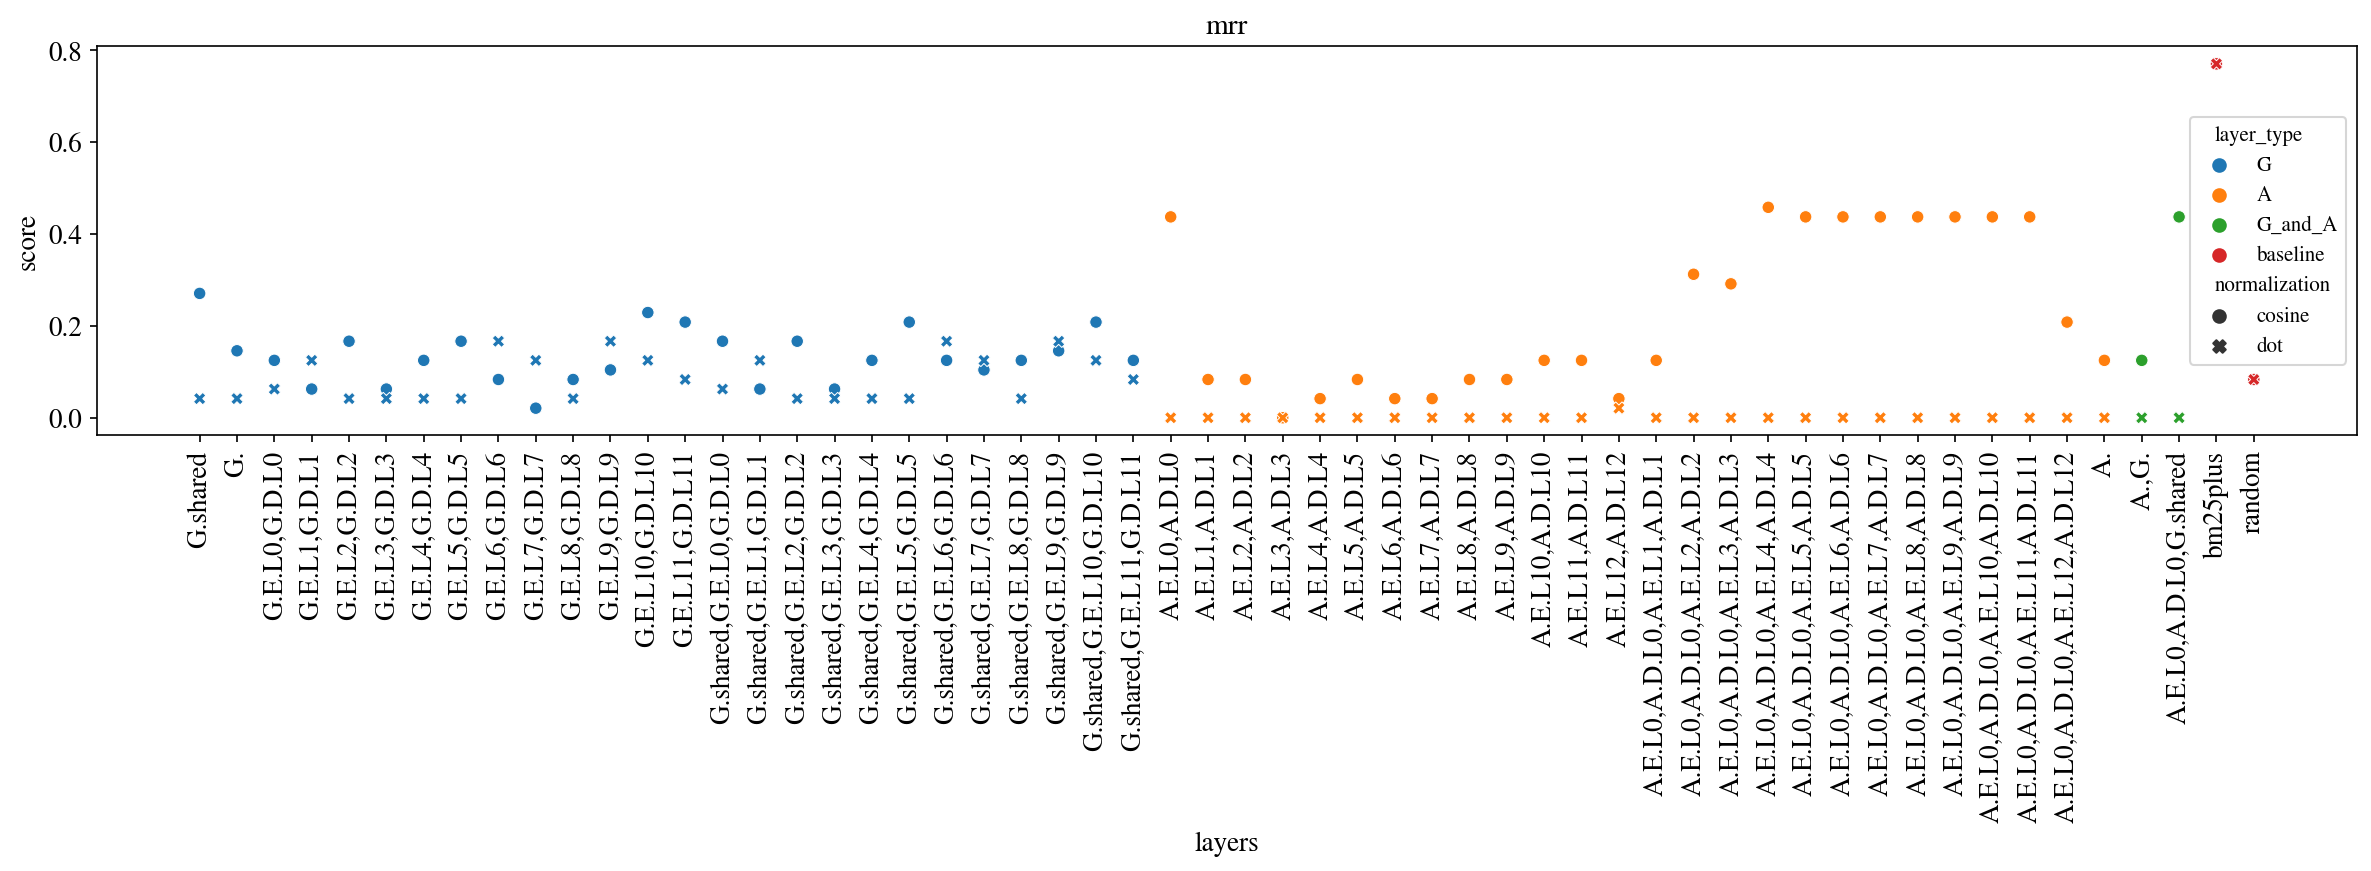

In [42]:
visualize_one_experiment(path='/reranker/bm2plus_wbaselines_eos_corrects_all.json')

## All with eos

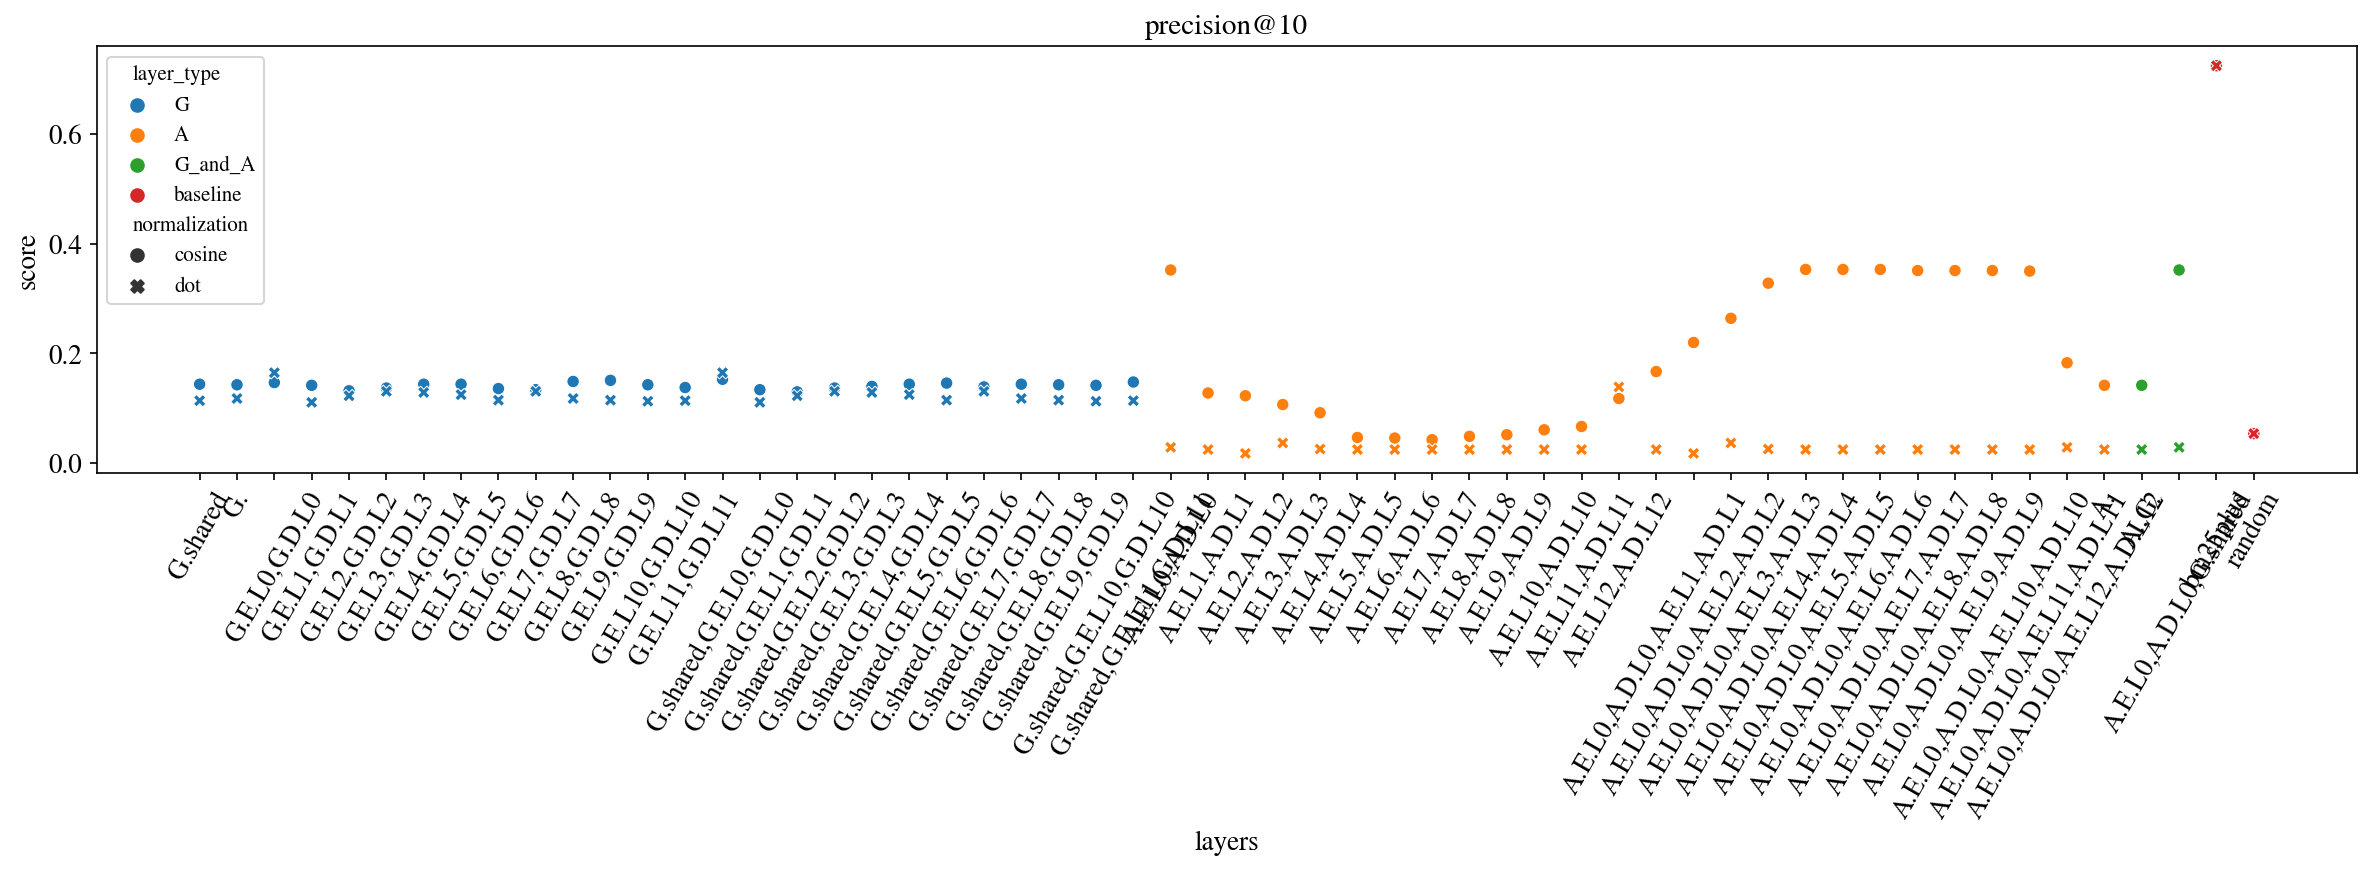

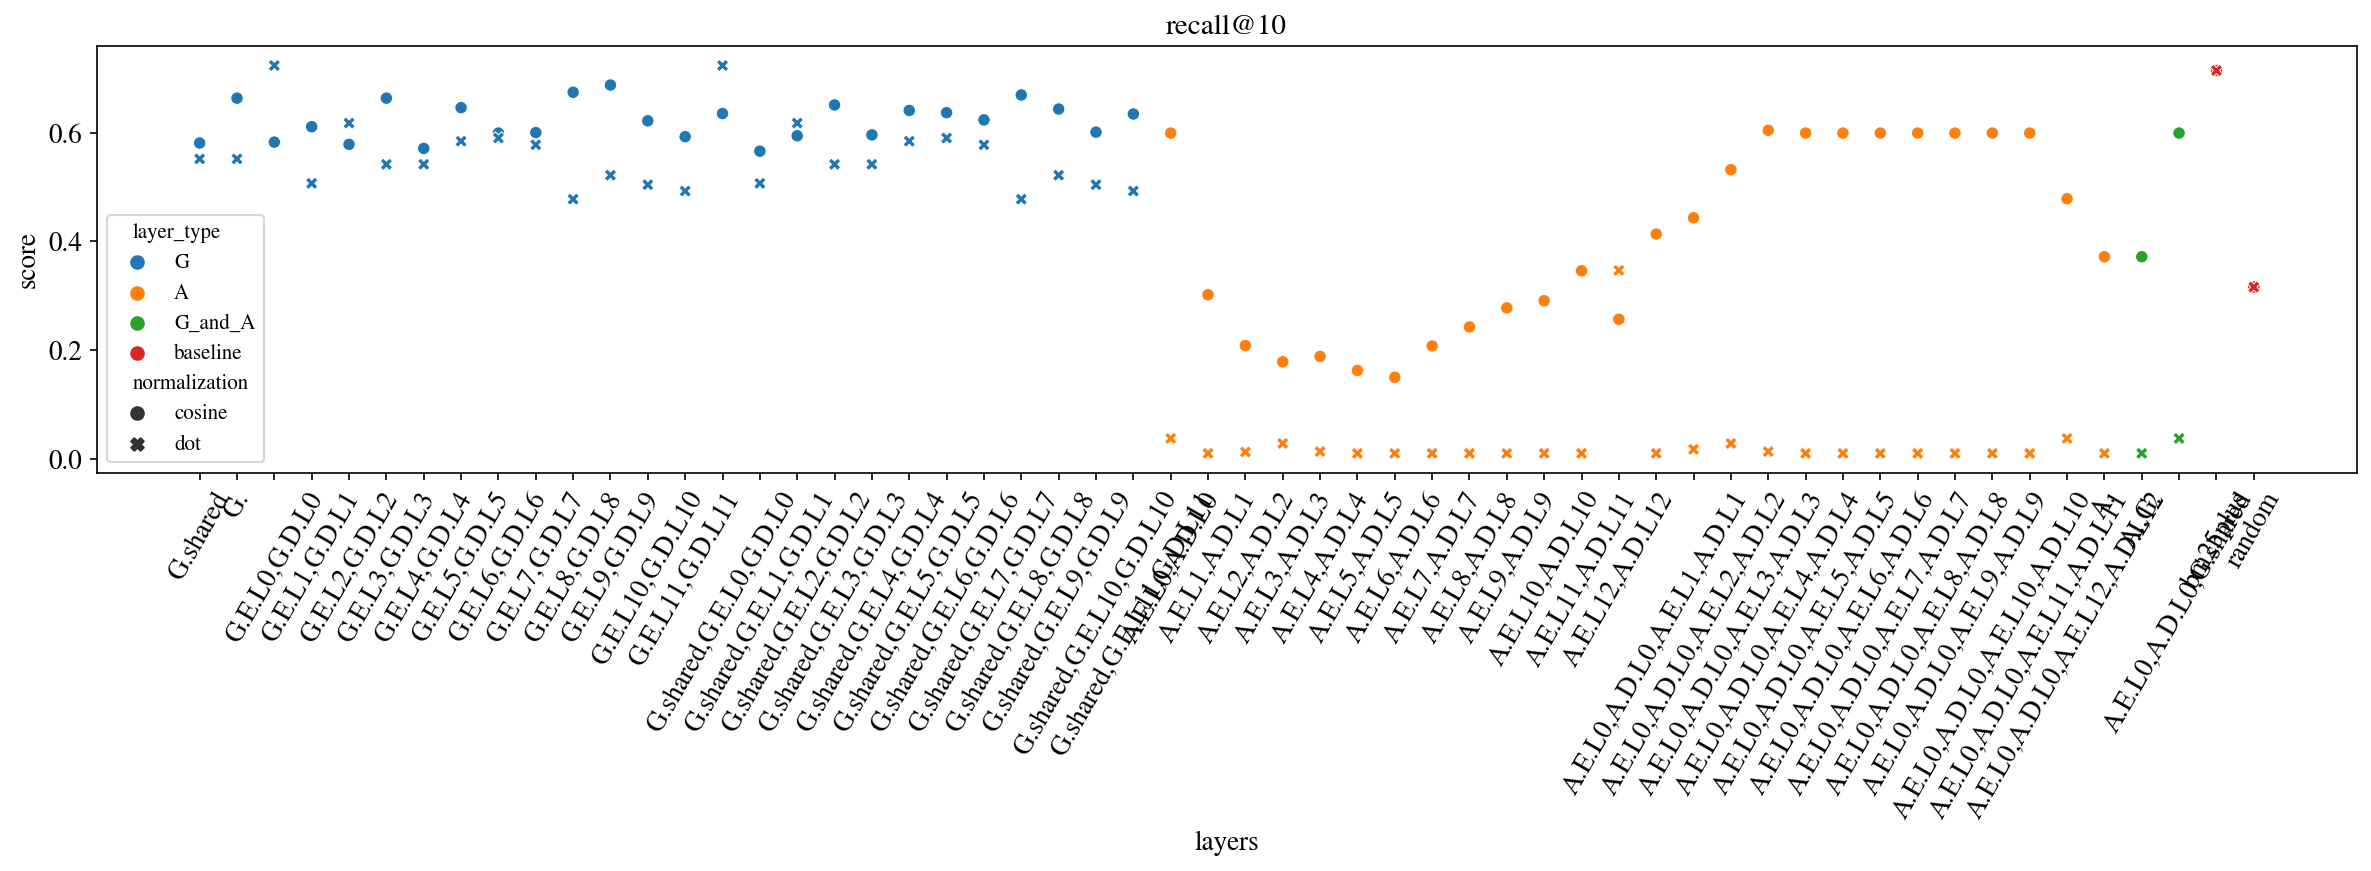

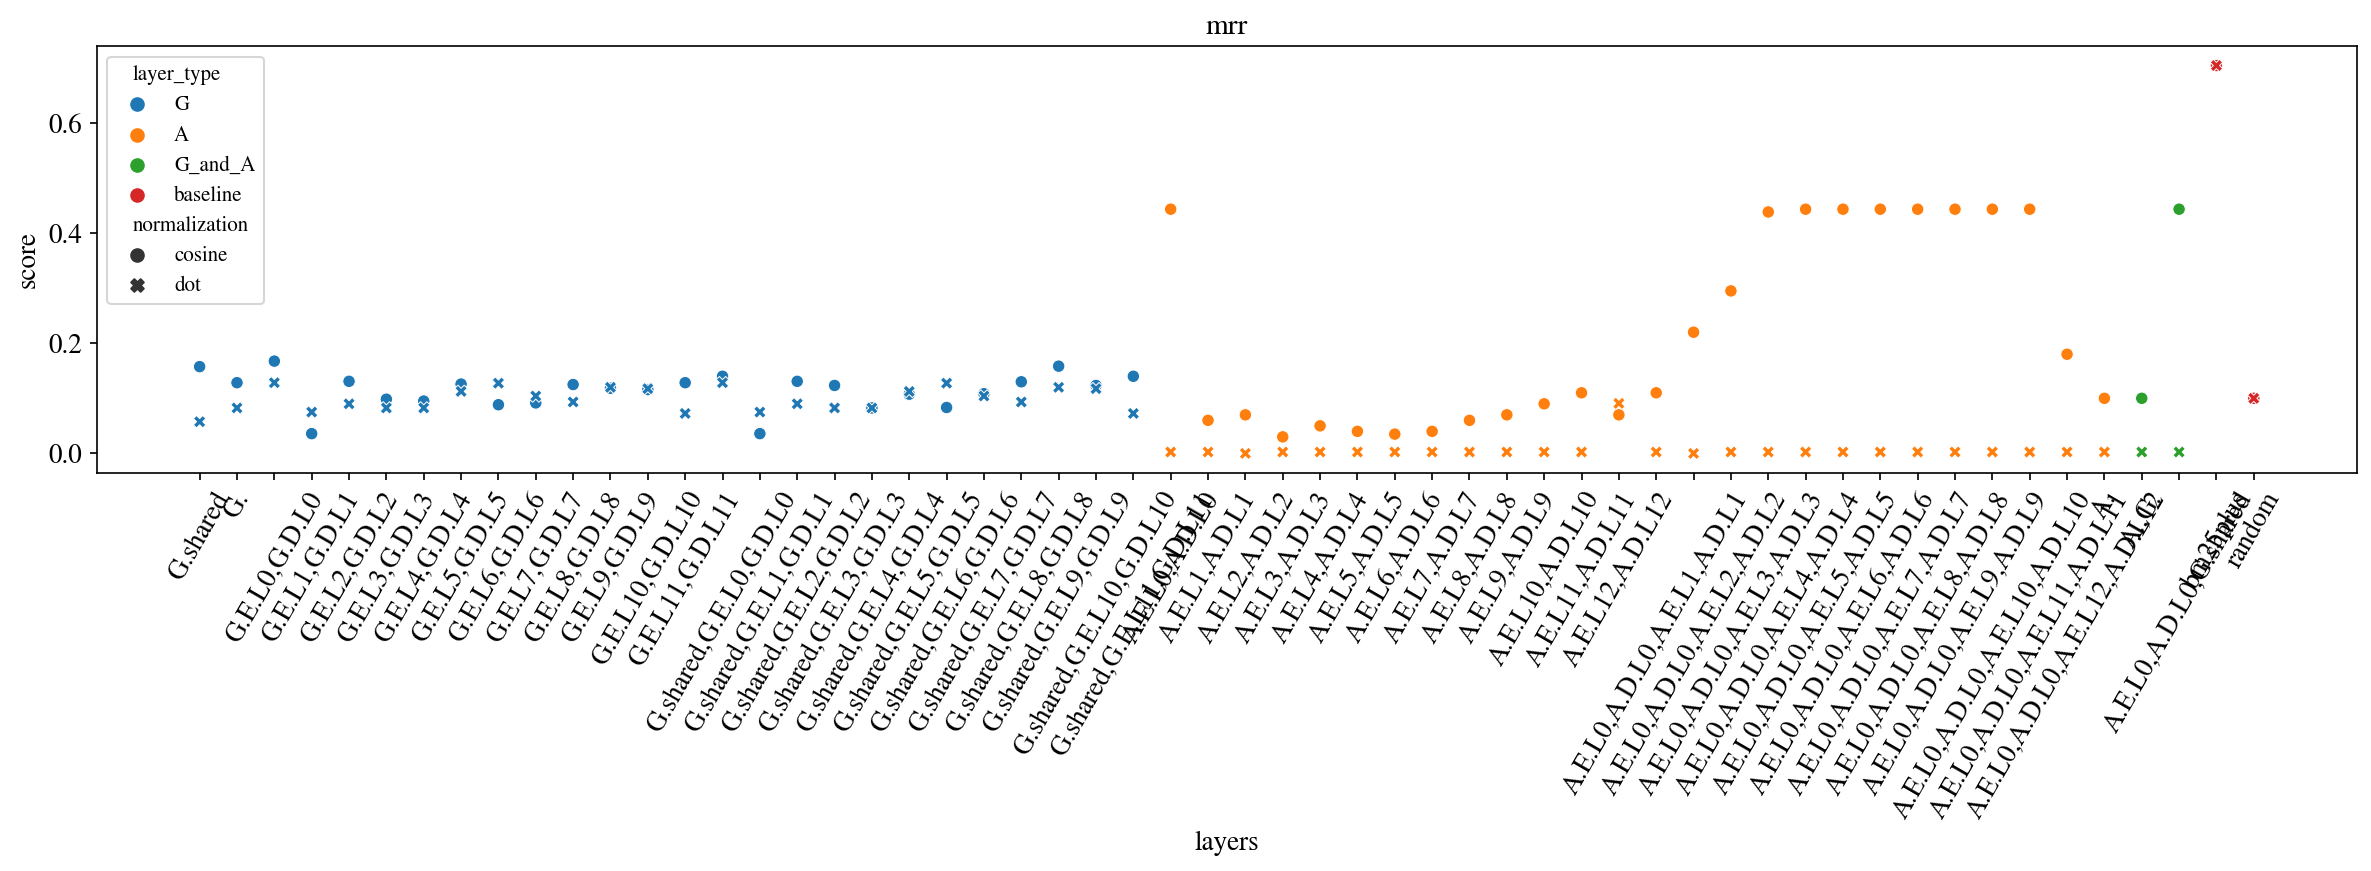

In [34]:
visualize_one_experiment(path='/reranker/bm2plus_wbaselines_eos_all.json')

## Without eos Corrects

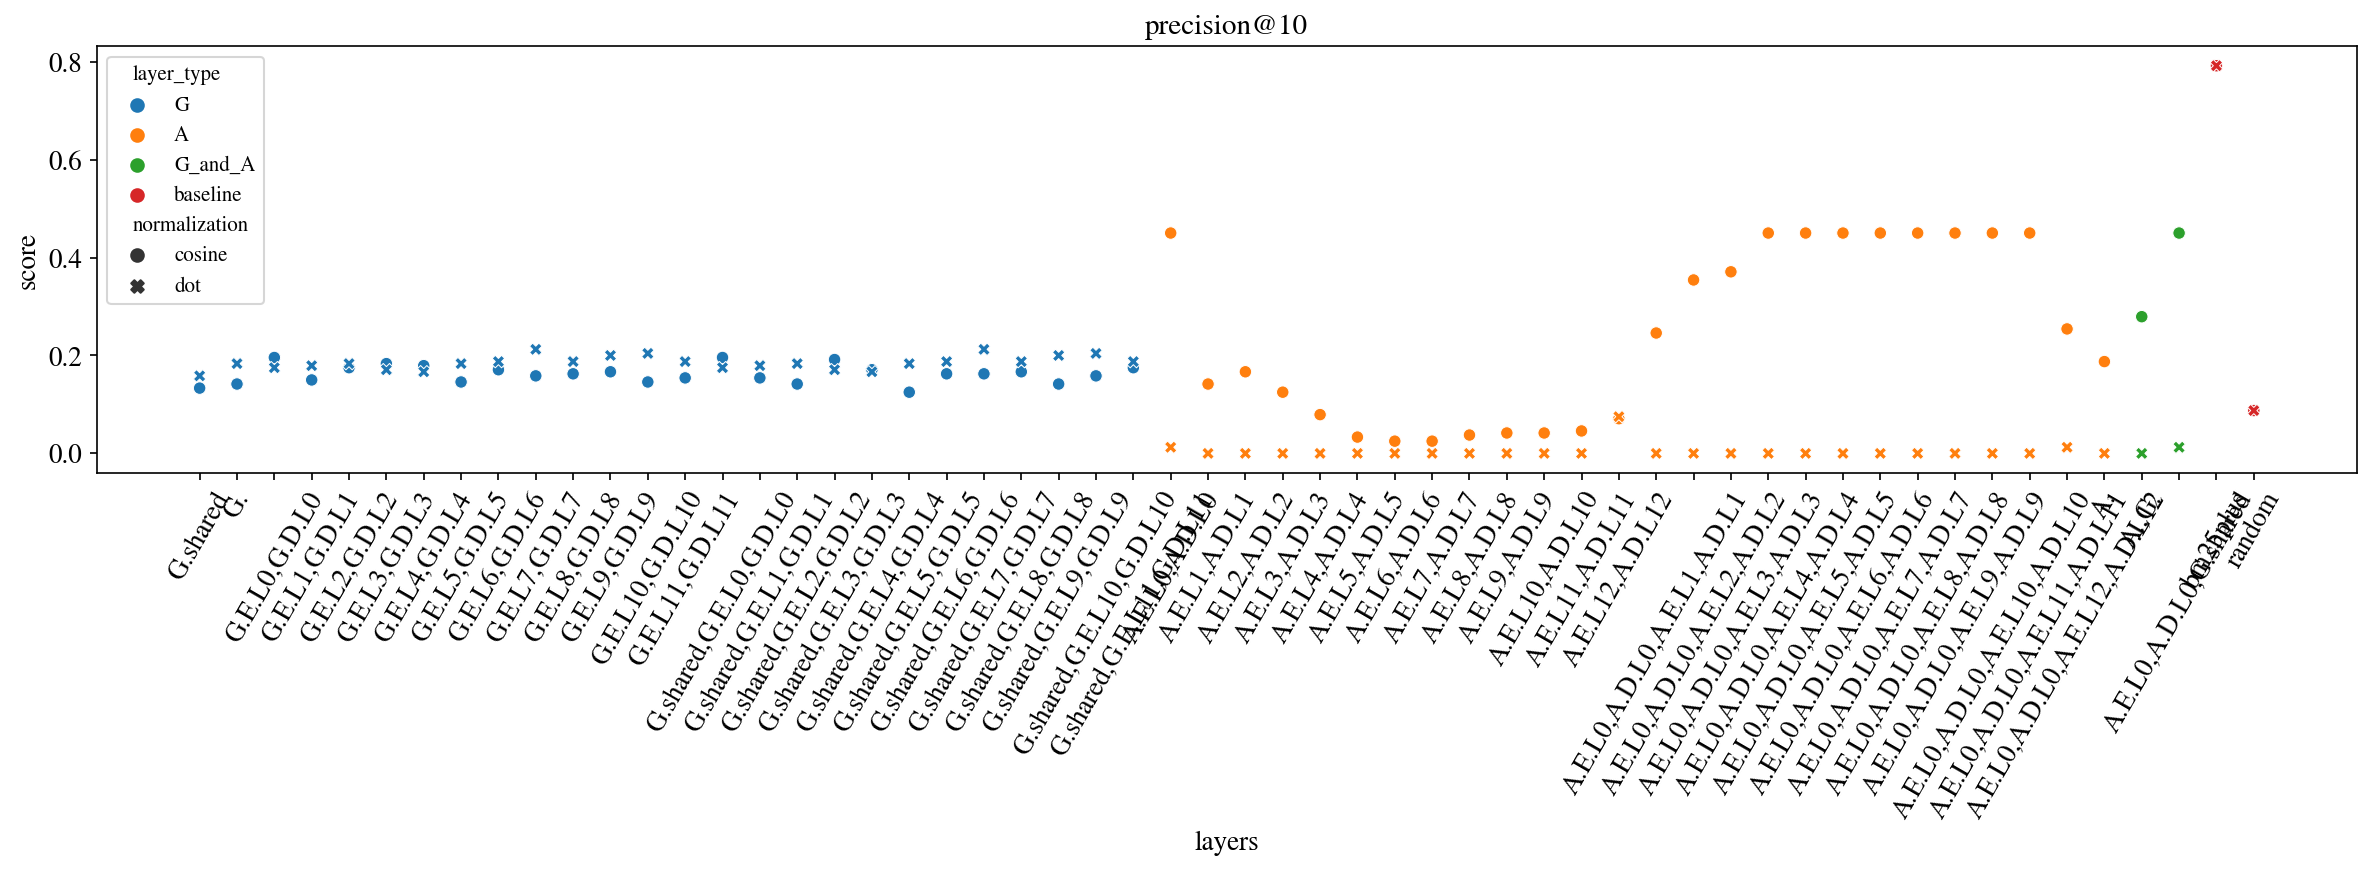

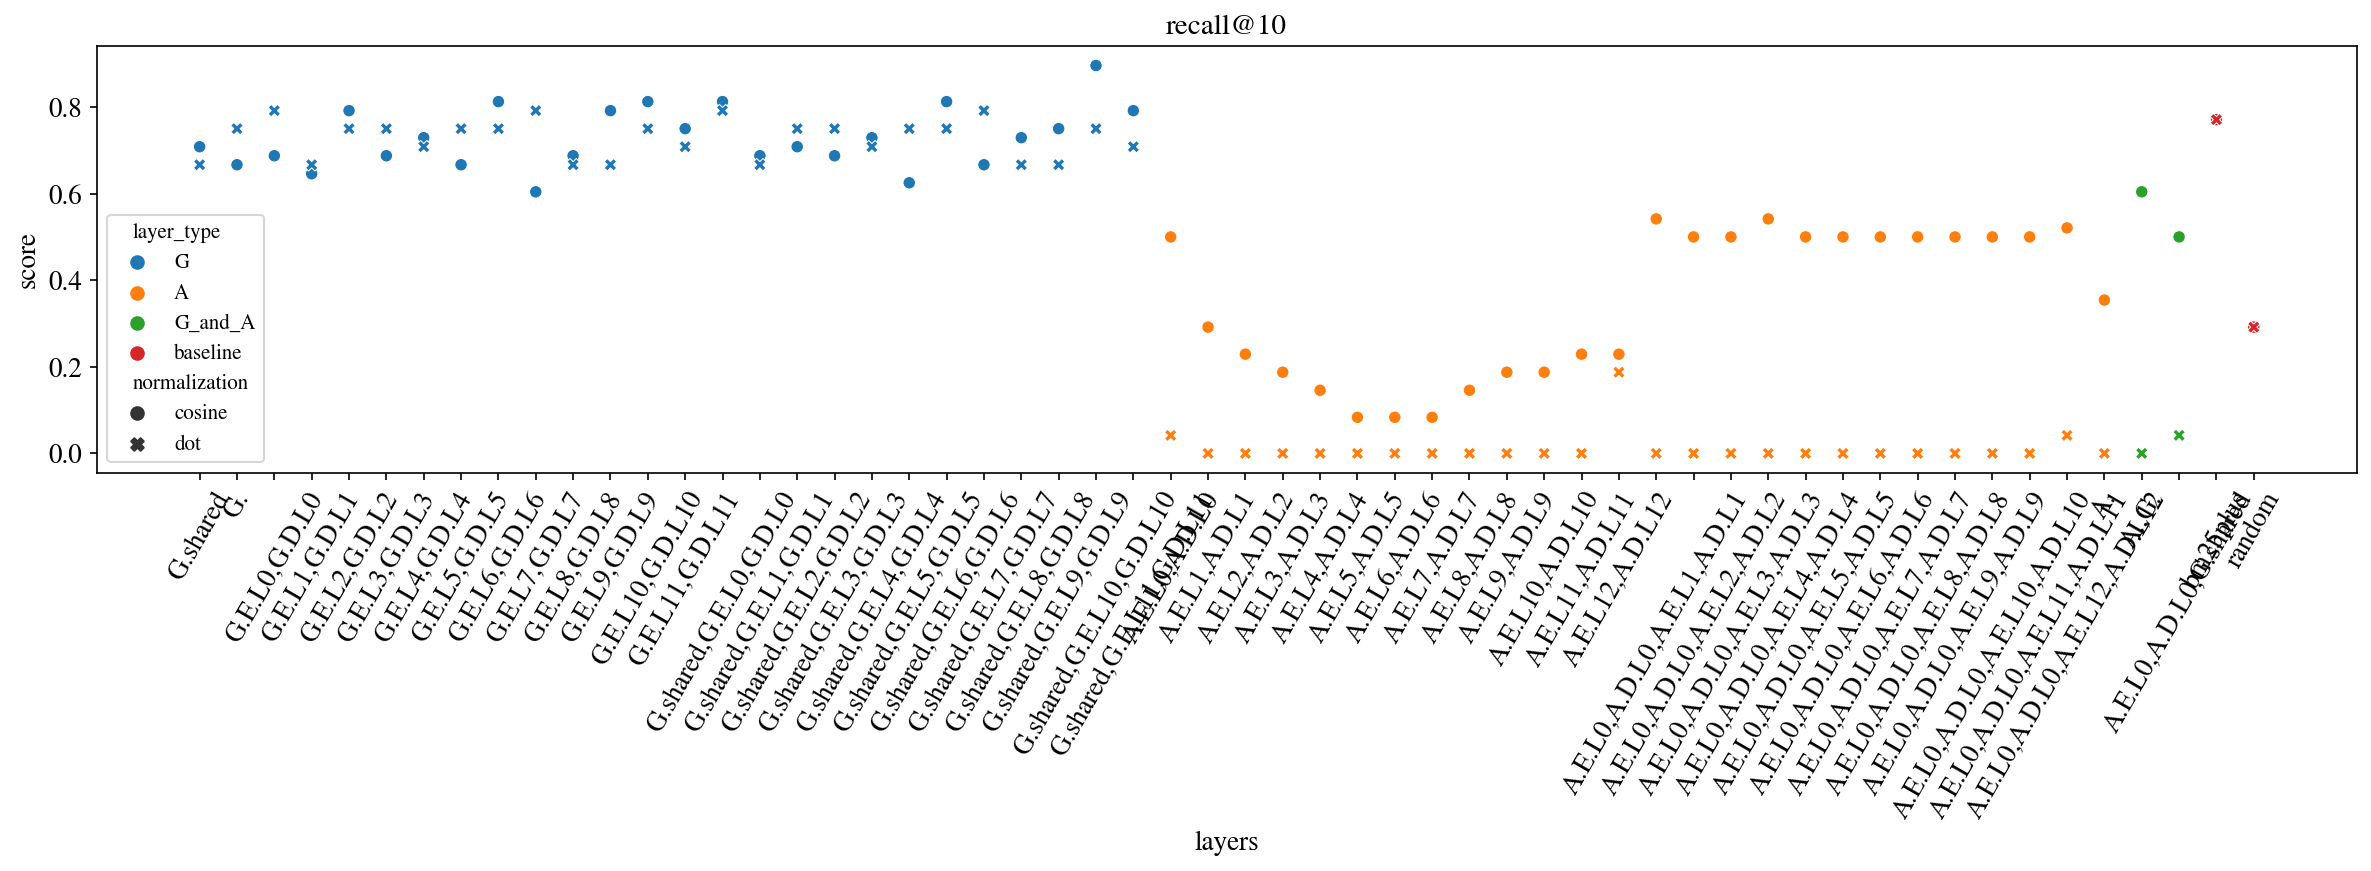

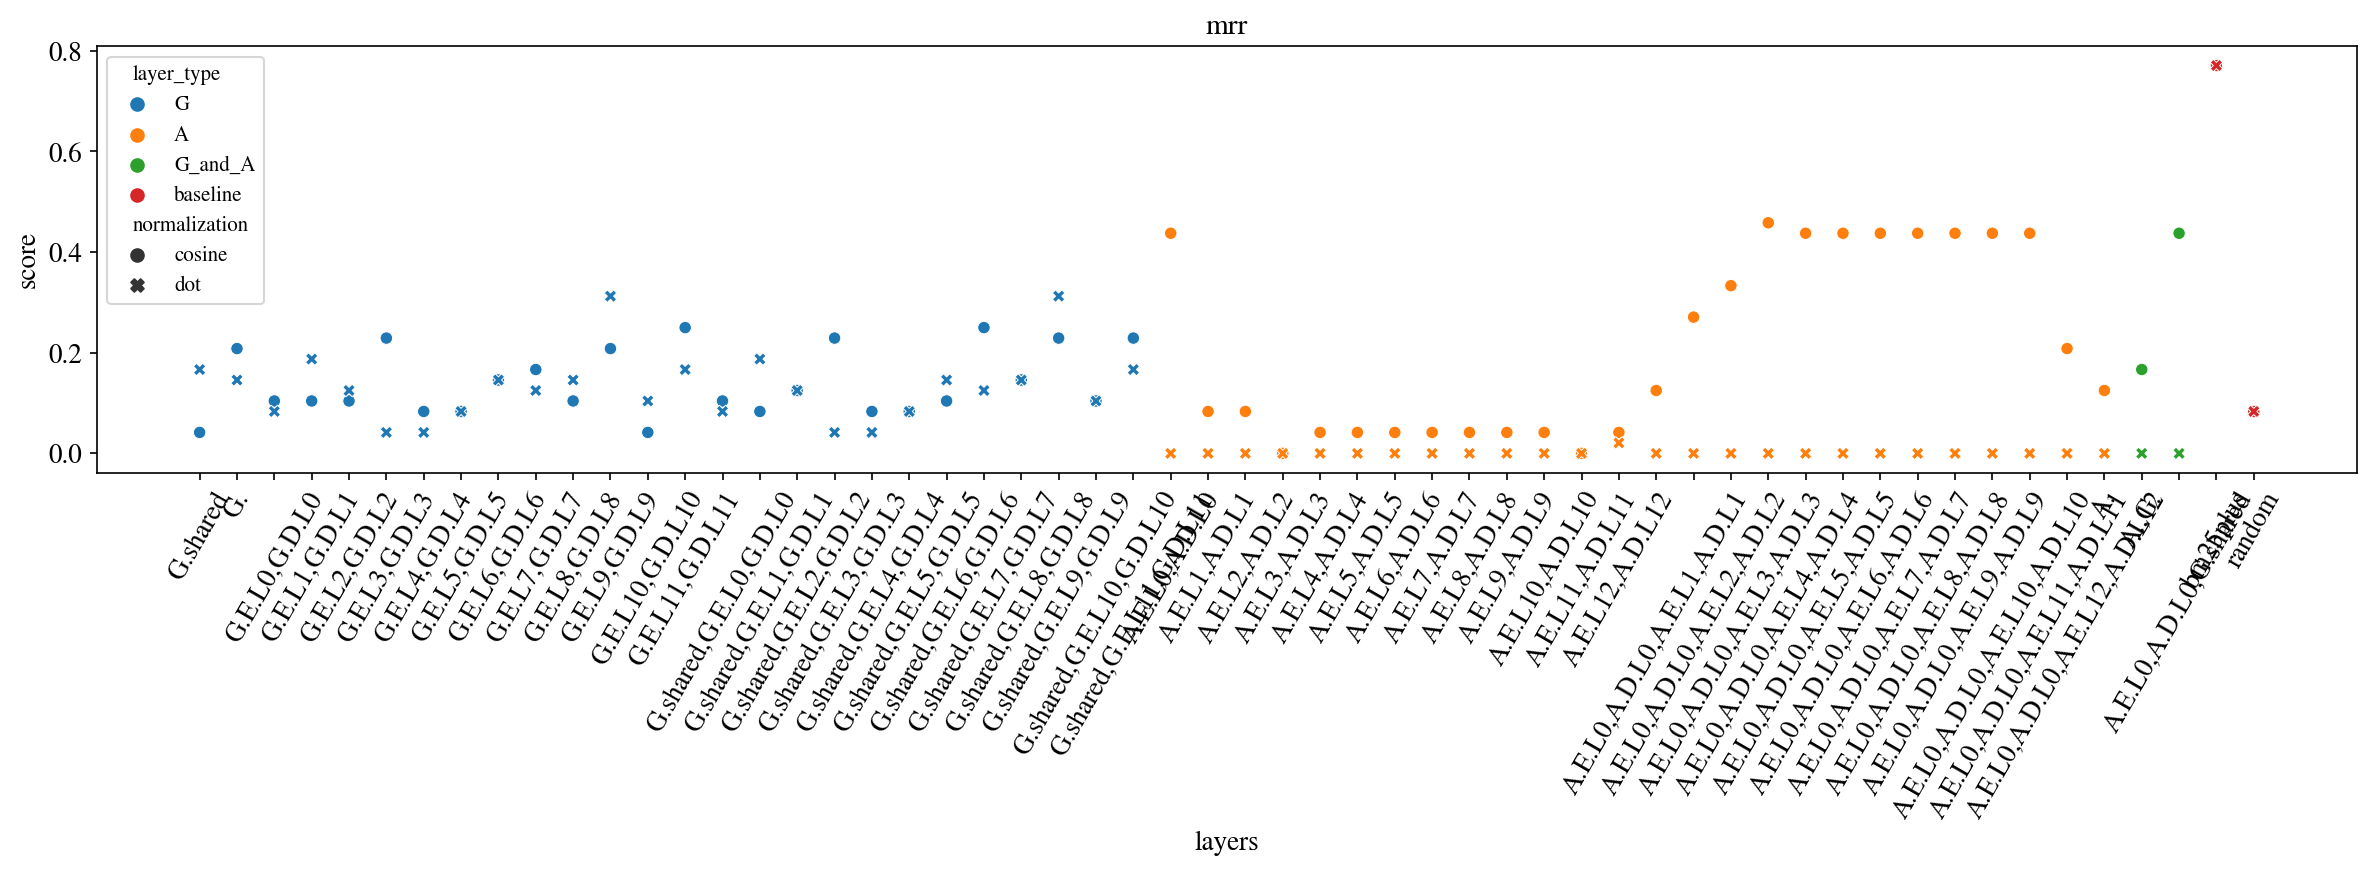

In [35]:
visualize_one_experiment(path='/reranker/bm2plus_wbaselines_no_eos_corrects_all.json')

In [36]:
def get_nn_abstracts(res):
  """Get list of abstracts and their scores (dotproduct score)"""
  print(res['example']['inputs_pretokenized']," -> ", res['example']['targets_pretokenized'])
  abstracts = np.array(res['nn_abstracts'])
  for i, abstract in enumerate(abstracts):
    try:
      abstract['score'] = res['nn_scores'][i]
    except KeyError:
      abstract['score'] = res['nn']['scores'][i]
  df = pd.DataFrame(pd.json_normalize(abstracts)).round(3)
  df['inputs_pretokenized'] = df['inputs_pretokenized'].str.slice(0,512)
  return df

In [37]:
path = '/reranker/bm2plus_wbaselines_eos_all.json'
with open(METRICS_DIR + path) as f:
      reranker_metrics = json.load(f)
      if 'mrr' not in reranker_metrics['dot']['random']:
          reranker_metrics['dot']['random'] = reranker_metrics['cosine']['random'] = average_metrics(reranker_metrics['dot']['random'])

In [38]:
i = 2
sim = 'cosine'
abstracts = get_nn_abstracts(reranker_metrics[sim]['activations.encoder.block.11,activations.decoder.block.11']['samples'][i])
display(abstracts)
abstracts = get_nn_abstracts(reranker_metrics[sim]['activations.encoder.block.0,activations.decoder.block.0']['samples'][i])
display(abstracts)

Beidha is located in <extra_id_0> .  ->  <extra_id_0> Jordan


,inputs_pretokenized,targets_pretokenized,page_uri,masked_uri,score
0,Mansaf (Arabic: ) is a traditional Jordanian a...,<extra_id_0> Jordan,Q3273642,Q810,2.000
1,The Madrid Conference of 1991 was a peace conf...,<extra_id_0> Jordan,Q1343802,Q810,2.000
2,Salt (Arabic: السلط Al-Salt ) is an ancient ag...,<extra_id_0> Jordan,Q867586,Q40059,2.000
3,"Beidha (Arabic: البيضا al-baīḍā, ""the white on...",<extra_id_0> Jordan,Q4881051,Q810,2.000
4,Kabsa (Arabic: كبسة kabsah) is a family of mix...,<extra_id_0> Jordan,Q1720857,Q810,2.000
...,...,...,...,...,...
95,"Beidha (Arabic: البيضا al-baīḍā, ""the white on...",<extra_id_0> BC,Q4881051,Q159791,1.999
96,"Beidha (Arabic: البيضا al-baīḍā, ""the white on...",<extra_id_0> position,Q4881051,P625,1.999
97,"Beidha (Arabic: البيضا al-baīḍā, ""the white on...",<extra_id_0> state,Q4881051,P17,1.999
98,Hugi Glacier (66°11′S65°7′W﻿ / ﻿66.183°S 65.11...,<extra_id_0> works,Q5933615,P800,1.999


Beidha is located in <extra_id_0> .  ->  <extra_id_0> Jordan


,inputs_pretokenized,targets_pretokenized,page_uri,masked_uri,score
0,"Baba ghanoush (Arabic بابا غنوج bābā ghannūj, ...",<extra_id_0> Jordan,Q1072192,Q810,1.587
1,Kabsa (Arabic: كبسة kabsah) is a family of mix...,<extra_id_0> Jordan,Q1720857,Q810,1.582
2,"Beidha (Arabic: البيضا al-baīḍā, ""the white on...",<extra_id_0> period,Q4881051,P2348,1.569
3,"Beidha (Arabic: البيضا al-baīḍā, ""the white on...",<extra_id_0> period,Q4881051,P2348,1.569
4,"Beidha (Arabic: البيضا al-baīḍā, ""the white on...",<extra_id_0> period,Q4881051,P2348,1.569
...,...,...,...,...,...
95,"Fathi Hamad (Arabic: فتحي حماد), also spelled ...",<extra_id_0> Jordan,Q2895660,Q810,1.506
96,"Syria (/ˈsɪ.rɪə/; Arabic: سوريا or سورية, Sūri...",<extra_id_0> Jordan,Q858,Q810,1.505
97,White is a surname either of <extra_id_0> or o...,<extra_id_0> English,Q1215200,Q1860,1.505
98,Israel (/ˈɪzreɪəl/ or /ˈɪzriːəl/; Hebrew: יִשְ...,<extra_id_0> Jordan,Q801,Q810,1.504


In [39]:
i = 2
sim = 'cosine'
abstracts = get_nn_abstracts(reranker_metrics[sim]['gradients.encoder.block.11,gradients.decoder.block.11']['samples'][i])
display(abstracts)
abstracts = get_nn_abstracts(reranker_metrics[sim]['gradients.encoder.block.0,gradients.decoder.block.0']['samples'][i])
display(abstracts)
abstracts = get_nn_abstracts(reranker_metrics[sim]['gradients.shared']['samples'][i])
display(abstracts)

Beidha is located in <extra_id_0> .  ->  <extra_id_0> Jordan


,inputs_pretokenized,targets_pretokenized,page_uri,masked_uri,score
0,The Hurley River is a major tributary of the B...,<extra_id_0> Hurley,Q269587,Q3266971,23.0
1,"Oswald Veblen (June 24, 1880 – August 10, 1960...",<extra_id_0> Jordan,Q536558,Q810,23.0
2,"Krokodil (Russian: ""Крокодил"", ""crocodile"") wa...",<extra_id_0> example,Q1586030,P1855,23.0
3,Symbian was a closed-source mobile operating s...,<extra_id_0> open-source,Q483318,Q39162,23.0
4,Penclawdd (Welsh: Pen-clawdd) is a village whi...,<extra_id_0> Gower Peninsula,Q3381195,Q1141148,23.0
...,...,...,...,...,...
95,The Kreutzer Sonata (Russian: Крейцерова сонат...,<extra_id_0> is a,Q1214091,P31,23.0
96,"Beidha (Arabic: البيضا al-baīḍā, ""the white on...",<extra_id_0> It,Q4881051,Q4881051,23.0
97,"William Nunn Lipscomb, Jr. (December 9, 1919 –...",<extra_id_0> biochemistry,Q110935,Q7094,23.0
98,Sky Atlantic is a television channel brand own...,<extra_id_0> director,Q3510971,P57,23.0


Beidha is located in <extra_id_0> .  ->  <extra_id_0> Jordan


,inputs_pretokenized,targets_pretokenized,page_uri,masked_uri,score
0,Fouad Twal (Arabic: البطريرك فؤاد طوال) (born ...,<extra_id_0> Jordan,Q124679,Q810,25.0
1,Indiana /ɪndiˈænə/ is a U.S. state located in ...,<extra_id_0> Indiana Pacers,Q1415,Q170329,25.0
2,Amman (/ɑːˈmɑːn/; Arabic: عمّان) is the capita...,<extra_id_0> Jordan,Q3805,Q810,25.0
3,Jerusalem (/dʒəˈruːsələm/; Hebrew: יְרוּשָׁלַי...,<extra_id_0> Jordan,Q1218,Q810,25.0
4,"Beidha (Arabic: البيضا al-baīḍā, ""the white on...",<extra_id_0> Petra,Q4881051,Q5788,25.0
...,...,...,...,...,...
95,"Polio vaccines, are vaccines used to prevent p...",<extra_id_0> developed by,Q1519099,P178,25.0
96,Zarqa Governorate (Arabic محافظة الزرقاء Muħāf...,<extra_id_0> population,Q721445,P1082,25.0
97,Zarqa Governorate (Arabic محافظة الزرقاء Muħāf...,<extra_id_0> Zarqa,Q721445,Q148062,25.0
98,"Petra (Arabic: البترا, Al-Batrāʾ; Ancient Gree...",<extra_id_0> Jordan,Q5788,Q810,25.0


Beidha is located in <extra_id_0> .  ->  <extra_id_0> Jordan


,inputs_pretokenized,targets_pretokenized,page_uri,masked_uri,score
0,"Beidha (Arabic: البيضا al-baīḍā, ""the white on...",<extra_id_0> obsidian,Q4881051,Q53754,1.0
1,Zarqa Governorate (Arabic محافظة الزرقاء Muħāf...,<extra_id_0> city,Q721445,P131,1.0
2,Jerusalem (/dʒəˈruːsələm/; Hebrew: יְרוּשָׁלַי...,<extra_id_0> Jordan,Q1218,Q810,1.0
3,East Jerusalem or Eastern Jerusalem (Arabic: ا...,<extra_id_0> Jordan,Q212938,Q810,1.0
4,Zarqa Governorate (Arabic محافظة الزرقاء Muħāf...,<extra_id_0> armed forces,Q721445,Q11211,1.0
...,...,...,...,...,...
95,Salt (Arabic: السلط Al-Salt ) is an ancient ag...,<extra_id_0> Jordan,Q867586,Q40059,1.0
96,"Saudi Arabia (/ˌsɔːdiː əˈreɪbiə/, /ˌsaʊ-/), of...",<extra_id_0> Jordan,Q851,Q810,1.0
97,Sempiternal is the fourth studio album by Brit...,<extra_id_0> Jordan,Q7449797,Q810,1.0
98,Simple Minds are a Scottish rock band formed i...,<extra_id_0> include,Q748836,P527,1.0
